####Using the NHL API to attempt to use various ML model types to predict points/game for players based on their performance in past seasons and information such as their age, position, nationality 
#####Thanks to Drew Hynes https://gitlab.com/dword4/nhlapi for mapping out the NHL API 

In [224]:
import requests
import tqdm
import pandas as pd
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error ,mean_squared_error, max_error

###1. Gathering Data from API

In [2]:
#Getting the ID's of all the teams in NHL
r = requests.get(url='http://statsapi.web.nhl.com/api/v1/teams')
data = r.json()
team_ids = []
for team in data['teams']:
  team_ids.append(team['id'])

In [3]:
#Getting the ID's of all active NHL players
player_ids = set()
for team in tqdm.tqdm(team_ids):
  r = requests.get(url=f'http://statsapi.web.nhl.com/api/v1/teams/{team}/roster')
  data = r.json()
  for player in data['roster']:
    player_ids.add(player['person']['id'])

100%|██████████| 31/31 [00:03<00:00,  9.43it/s]


In [7]:
#Getting the per season statistics for each currently active player for the last 5 seasons and their current age, position(forward/defence/goalie), and nationality
ages_dict ={}
position_dict = {}
nationality_dict = {}

stats_dict =  {player : [] for player in player_ids }
seasons = ['20152016','20162017','20172018','20182019','20192020']
for season in seasons:
  for player in tqdm.tqdm(player_ids):
      r = requests.get(url=f'http://statsapi.web.nhl.com/api/v1/people/{player}/stats?stats=statsSingleSeason&season={season}')
      data = r.json()
      stats_dict[player].append(data['stats'][0]['splits'])
      r = requests.get(url=f'http://statsapi.web.nhl.com/api/v1/people/{player}')
      data = r.json()
      ages_dict[player] = data['people'][0]['currentAge']
      position_dict[player] = data['people'][0]['primaryPosition']['type']
      nationality_dict[player] = data['people'][0]['nationality']

100%|██████████| 1139/1139 [02:22<00:00,  7.99it/s]


###2. Creating Dataframe and Features

In [603]:
#Getting input data into format of pandas dataframe for easier analysis and input into model
examples = pd.DataFrame()
for player in stats_dict.keys():

  #We only want to include players who have played at least 5 games in each of the last five seasons and remove goalies
  if any([((len(x) == 0) or (x[0]['stat']['games'] < 5)) for x in stats_dict[player]]) or position_dict[player] == 'Goalie':
    continue

  #Our dataframe will have the age of each player as well as their points/game and shot percentage over the last five seasons
  examples = examples.append({'player_id':player,
                              'age': ages_dict[player],
                              'position': position_dict[player],
                              'nationality' : nationality_dict[player],
                              '20152016p/g': stats_dict[player][0][0]['stat']['points']/stats_dict[player][0][0]['stat']['games'],
                              '20152016Pct': stats_dict[player][0][0]['stat']['shotPct'],
                              '20162017p/g': stats_dict[player][1][0]['stat']['points']/stats_dict[player][1][0]['stat']['games'],
                              '20162017Pct': stats_dict[player][1][0]['stat']['shotPct'],                              
                              '20172018p/g': stats_dict[player][2][0]['stat']['points']/stats_dict[player][2][0]['stat']['games'],
                              '20172018Pct': stats_dict[player][2][0]['stat']['shotPct'],
                              '20182019p/g': stats_dict[player][3][0]['stat']['points']/stats_dict[player][3][0]['stat']['games'],
                              '20182019Pct': stats_dict[player][3][0]['stat']['shotPct'],
                              '20192020p/g': stats_dict[player][4][0]['stat']['points']/stats_dict[player][4][0]['stat']['games']},ignore_index=True)
  
#We will use player_id for the index of our dataframe since it is a unique identifier
examples.set_index('player_id',inplace=True)

In [597]:
#Make copy in case of error
orig_examples= examples.copy(deep=True)

In [607]:
#Inital look at data
examples.describe()

,20152016Pct,20152016p/g,20162017Pct,20162017p/g,20172018Pct,20172018p/g,20182019Pct,20182019p/g,20192020p/g,age
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,8.875140,0.452971,8.653771,0.468005,8.945670,0.505453,8.911229,0.507049,0.485896,29.611732
std,5.089786,0.251677,4.654517,0.248394,4.445031,0.272010,4.801748,0.283596,0.283200,3.336006
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000
25%,5.477500,0.253254,5.000000,0.265885,5.665000,0.278714,5.135000,0.292402,0.263406,27.000000
50%,8.745000,0.431363,8.565000,0.450000,8.805000,0.463415,8.900000,0.455536,0.437500,29.000000
75%,12.292500,0.627404,11.912500,0.651970,12.395000,0.683390,12.352500,0.678534,0.647680,32.000000
max,40.000000,1.292683,23.080000,1.219512,23.370000,1.317073,22.220000,1.487179,1.549296,43.000000


####Quick Looks

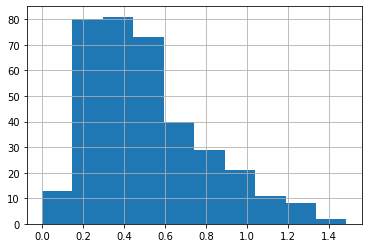

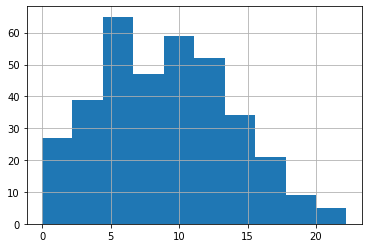

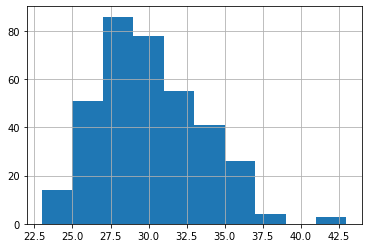

In [601]:
examples['20182019p/g'].hist()
plt.show()
examples['20182019Pct'].hist()
plt.show()
examples['age'].hist()

In [608]:
examples['position'].value_counts()

Forward       232
Defenseman    126
Name: position, dtype: int64

In [609]:
examples['nationality'].value_counts()

CAN    174
USA     91
SWE     39
FIN     14
RUS     10
CZE      9
CHE      4
DNK      4
SVK      4
FRA      3
DEU      2
NOR      1
LVA      1
SVN      1
AUT      1
Name: nationality, dtype: int64

####Creating Features

In [82]:
#Creating variable indicating if player is from North America or Europe
examples['continent'] = examples['nationality'].map(lambda x:'NA' if x in ['CAN','USA'] else "EUR")

#Remove inital nationality varaible
examples.drop(columns=['nationality'],inplace=True)

#Creating dummy variables to indicate player position and continent
examples = pd.get_dummies(examples,columns=['position','continent'])

In [83]:
#Taking a peak at where were at
examples.head(1)

,20152016Pct,20152016p/g,20162017Pct,20162017p/g,20172018Pct,20172018p/g,20182019Pct,20182019p/g,20192020p/g,age,position_Defenseman,position_Forward,continent_EUR,continent_NA
player_id,,,,,,,,,,,,,,
8474641.0,20.13,0.625,14.08,0.487805,15.89,0.617284,14.75,0.512195,0.605634,30.0,0,1,0,1


In [84]:
#Perform XScale necessary columns between 0 and 1
stats_to_scale = ['20152016Pct','20152016p/g','20162017Pct','20162017p/g','20172018Pct','20172018p/g','20182019Pct','20182019p/g','20192020p/g','age']
scalers = {stat : MinMaxScaler() for stat in stats_to_scale}
for stat in scalers.keys():
  examples[[stat]] = scalers[stat].fit_transform(examples[[stat]])

####Final looks at data

In [593]:
examples.describe()

,20152016Pct,20152016p/g,20162017Pct,20162017p/g,20172018Pct,20172018p/g,20182019Pct,20182019p/g,20192020p/g,age,position_Defenseman,position_Forward,continent_EUR,continent_NA
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,0.221878,0.350412,0.374947,0.383764,0.382784,0.383770,0.401045,0.340947,0.313624,0.330587,0.351955,0.648045,0.259777,0.740223
std,0.127245,0.194693,0.201669,0.203683,0.190202,0.206526,0.216100,0.190694,0.182792,0.166800,0.478249,0.478249,0.439126,0.439126
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.136938,0.195913,0.216638,0.218026,0.242405,0.211616,0.231098,0.196615,0.170017,0.200000,0.000000,0.000000,0.000000,0.000000
50%,0.218625,0.333696,0.371101,0.369000,0.376765,0.351852,0.400540,0.306308,0.282386,0.300000,0.000000,1.000000,0.000000,1.000000
75%,0.307312,0.485350,0.516140,0.534615,0.530381,0.518870,0.555918,0.456256,0.418048,0.450000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [592]:
examples.corr()

,20152016Pct,20152016p/g,20162017Pct,20162017p/g,20172018Pct,20172018p/g,20182019Pct,20182019p/g,20192020p/g,age,position_Defenseman,position_Forward,continent_EUR,continent_NA
20152016Pct,1.000000,0.533074,0.535331,0.478014,0.446117,0.373788,0.488132,0.364189,0.362410,0.098328,-0.567947,0.567947,0.037776,-0.037776
20152016p/g,0.533074,1.000000,0.420551,0.801321,0.359418,0.750088,0.379261,0.692597,0.627578,0.256034,-0.310834,0.310834,0.064198,-0.064198
20162017Pct,0.535331,0.420551,1.000000,0.620667,0.591377,0.468460,0.596147,0.460681,0.438626,0.086904,-0.606144,0.606144,0.058641,-0.058641
20162017p/g,0.478014,0.801321,0.620667,1.000000,0.419184,0.801349,0.464624,0.761033,0.709142,0.148393,-0.357061,0.357061,0.057570,-0.057570
20172018Pct,0.446117,0.359418,0.591377,0.419184,1.000000,0.568436,0.626232,0.480598,0.510164,-0.016610,-0.699130,0.699130,0.086466,-0.086466
20172018p/g,0.373788,0.750088,0.468460,0.801349,0.568436,1.000000,0.462469,0.845980,0.793329,0.033504,-0.353861,0.353861,0.062254,-0.062254
20182019Pct,0.488132,0.379261,0.596147,0.464624,0.626232,0.462469,1.000000,0.621308,0.528544,-0.039694,-0.675272,0.675272,0.020094,-0.020094
20182019p/g,0.364189,0.692597,0.460681,0.761033,0.480598,0.845980,0.621308,1.000000,0.831181,-0.050438,-0.356102,0.356102,0.065081,-0.065081
20192020p/g,0.362410,0.627578,0.438626,0.709142,0.510164,0.793329,0.528544,0.831181,1.000000,-0.151591,-0.368014,0.368014,0.128810,-0.128810
age,0.098328,0.256034,0.086904,0.148393,-0.016610,0.033504,-0.039694,-0.050438,-0.151591,1.000000,0.034977,-0.034977,-0.068628,0.068628


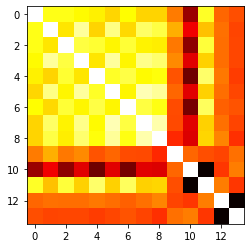

In [591]:
plt.imshow(examples.corr().to_numpy(),cmap='hot')

###3. Model Training and Evaluation

In [86]:
#Seperating Train and Test Data
y = examples['20192020p/g']
X = examples.drop(columns=['20192020p/g'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

###Linear Regression

In [577]:
#Getting baseline performance with linear regression model
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression().fit(X_train.to_numpy(),y_train.to_numpy())

In [578]:
scores = cross_val_score(LinearRegression(),X_train.to_numpy(),y_train.to_numpy(),cv=5,scoring='neg_mean_squared_error')
print(np.mean(scores* -1))
print(np.mean((scores* -1) ** 0.5 ))

0.0088873175054421
0.09292743714519958


In [579]:
#Getting Model performance on test set
y_pred = lin_model.predict(X_test.to_numpy())

In [580]:
print(mean_squared_error(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))

0.00914839764946366
0.07894002769181926


In [581]:
#Unscaling y output to get true Mean absolute error in predictiing Points/Game
y_pred_unscaled = scalers['20192020p/g'].inverse_transform(y_pred.reshape(-1,1))
y_test_unscaled = scalers['20192020p/g'].inverse_transform(y_test.to_numpy().reshape(-1,1))

In [582]:
#Intuitive measure of model performance is the average magnitude of its error in predicting unscaled points per game
print(mean_absolute_error(y_test_unscaled,y_pred_unscaled))
print(max_error(y_test_unscaled,y_pred_unscaled))

0.1223014513535228
0.37309796848066135


###XGBoost

In [178]:
# Set the parameters by cross-validation
tuned_parameters = [
                  {'booster': ['gbtree'],
                   "n_estimators" : [50, 100, 200, 500],
                   "learning_rate"    : [0.02,0.05, 0.10, 0.15, 0.25 ] ,
                    "max_depth"        : [ 3, 4, 6, 10],
                    "min_child_weight" : [ 1, 3, 5, 7 ],
                    "gamma"            : [ 0.0, 0.1, 0.2 ],
                    "colsample_bytree" : [ 0.5 , 0.7, 1.0 ] },

                  {'booster': ['gblinear']},
                  
                  ]
clf = GridSearchCV(XGBRegressor(objective='reg:squarederror'), tuned_parameters, cv=3,scoring='neg_mean_squared_error',verbose=2,n_jobs=-1)
clf.fit(X_train.to_numpy(), y_train.to_numpy())

Fitting 3 folds for each of 2881 candidates, totalling 8643 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 1382 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 2514 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3974 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 5754 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7862 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 8643 out of 8643 | elapsed:  7.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=...
             iid='deprecated', n_jobs=-1,
             param_grid=[{'booster': ['gbtree'],
                          'colsample_bytree': [0.5, 0.7, 1.0],
                          'gamma': [0.0, 0.1, 0.2],
                          'learning_rate': [0.02, 0.05, 0.1, 0.15, 0.25],
                          'max_depth': [3, 4, 

In [ ]:
#Viewing search results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, std, params in zip(means, stds, params):
    print(f"{mean:.3f} 2*std : {std:.3f} for {params}")

In [192]:
print(clf.best_params_)
print(clf.best_score_)
print((clf.best_score_ * -1)** 0.5)

{'booster': 'gbtree', 'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}
-0.010221188511337858
0.10109989372565066


In [560]:
scores = cross_val_score(XGBRegressor(objective='reg:squarederror',booster='gbtree',n_estimators=100,max_depth= 3,learning_rate=0.05,min_child_weight=3,gamma=0.0),X_train.to_numpy(),y_train.to_numpy(),cv=3,scoring='neg_mean_squared_error')
print(np.mean(scores* -1))
print(np.mean((scores* -1) ** 0.5 ))

0.010523037878305943
0.10208307394596565


In [586]:
scores = cross_val_score(XGBRegressor(objective='reg:squarederror',booster='gblinear',reg_alpha=0,reg_lambda=0,updater='coord_descent'),X_train.to_numpy(),y_train.to_numpy(),cv=3,scoring='neg_mean_squared_error')
print(np.mean(scores* -1))
print(np.mean((scores* -1) ** 0.5 ))

0.009580567815885186
0.09731692681849076


In [564]:
#Training with full train set
out_tree_model = XGBRegressor(objective='reg:linear',booster='gbtree',n_estimators=100,max_depth= 2,learning_rate=0.5,min_child_weight=3,gamma=0.0,reg_alpha=2,reg_lambda=2).fit(X_train.to_numpy(),y_train.to_numpy())

[06:23:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [583]:
out_linear_model = XGBRegressor(objective='reg:linear',updater='coord_descent',booster='gblinear',reg_alpha=0,reg_lambda=0).fit(X_train.to_numpy(),y_train.to_numpy())

[06:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [584]:
#Getting Model performance on test set
y_pred_linear = out_linear_model.predict(X_test.to_numpy())
y_pred_tree = out_tree_model.predict(X_test.to_numpy())

In [585]:
#MSE and MAE of Scaled data
print('Tree')
print(mean_squared_error(y_test,y_pred_tree))
print(mean_absolute_error(y_test,y_pred_tree))
print('Linear')
print(mean_squared_error(y_test,y_pred_linear))
print(mean_absolute_error(y_test,y_pred_linear))

Tree
0.010318710155460733
0.07944750739312743
Linear
0.00960616947224997
0.07817984308160059


In [574]:
#Linear model appears to perform slighly better
y_pred = y_pred_linear

In [575]:
#Unscaling y output to get true Mean absolute error in predictiing Points/Game
y_pred_unscaled = scalers['20192020p/g'].inverse_transform(y_pred.reshape(-1,1))
y_test_unscaled = scalers['20192020p/g'].inverse_transform(y_test.to_numpy().reshape(-1,1))

In [576]:
#Intuitive measure of model performance is the average magnitude of its error in predicting unscaled points per game
print(mean_absolute_error(y_test_unscaled,y_pred_unscaled))
print(max_error(y_test_unscaled,y_pred_unscaled))

0.12112370065681136
0.38303507410961646


####The XGBoost and Linear Regression models perform quite similarly with the linear XGBoost model seeming to perform the best by a marginal amount, this may be because of the very small size of our input dataset

####4. Random Analysis

In [226]:
y_idk = pd.DataFrame(y_test)

In [227]:
y_idk['test_unscaled'] = y_test_unscaled 
y_idk['pred_unscaled'] = y_pred_unscaled 
y_idk.drop(columns=['20192020p/g'],inplace=True)

In [228]:
def name_f(x):
  r = requests.get(url=f'http://statsapi.web.nhl.com/api/v1/people/{x}')
  data = r.json()
  return data['people'][0]['fullName']

In [229]:
y_idk['name'] = y_idk.index.map(lambda x: name_f(x))

In [235]:
y_compare = y_idk.join(orig_examples)
y_compare.drop(columns = ['20152016Pct','20162017Pct','20172018Pct','20182019Pct'],inplace=True)
y_compare['error'] = abs(y_compare['test_unscaled'] - y_compare['pred_unscaled'])
y_compare.reset_index(inplace=True)

(array([7., 6., 5., 9., 4., 6., 7., 4., 5., 6., 2., 3., 0., 1., 2., 0., 0.,
        2., 1., 2.]),
 array([0.0005751 , 0.02004083, 0.03950657, 0.0589723 , 0.07843804,
        0.09790377, 0.11736951, 0.13683524, 0.15630098, 0.17576671,
        0.19523244, 0.21469818, 0.23416391, 0.25362965, 0.27309538,
        0.29256112, 0.31202685, 0.33149258, 0.35095832, 0.37042405,
        0.38988979]),
 <a list of 20 Patch objects>)

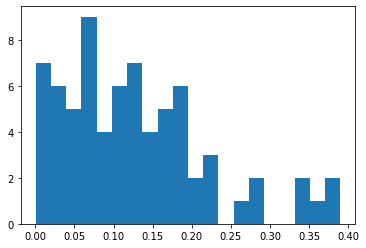

In [248]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(y_compare['error'].to_numpy(),bins=20)

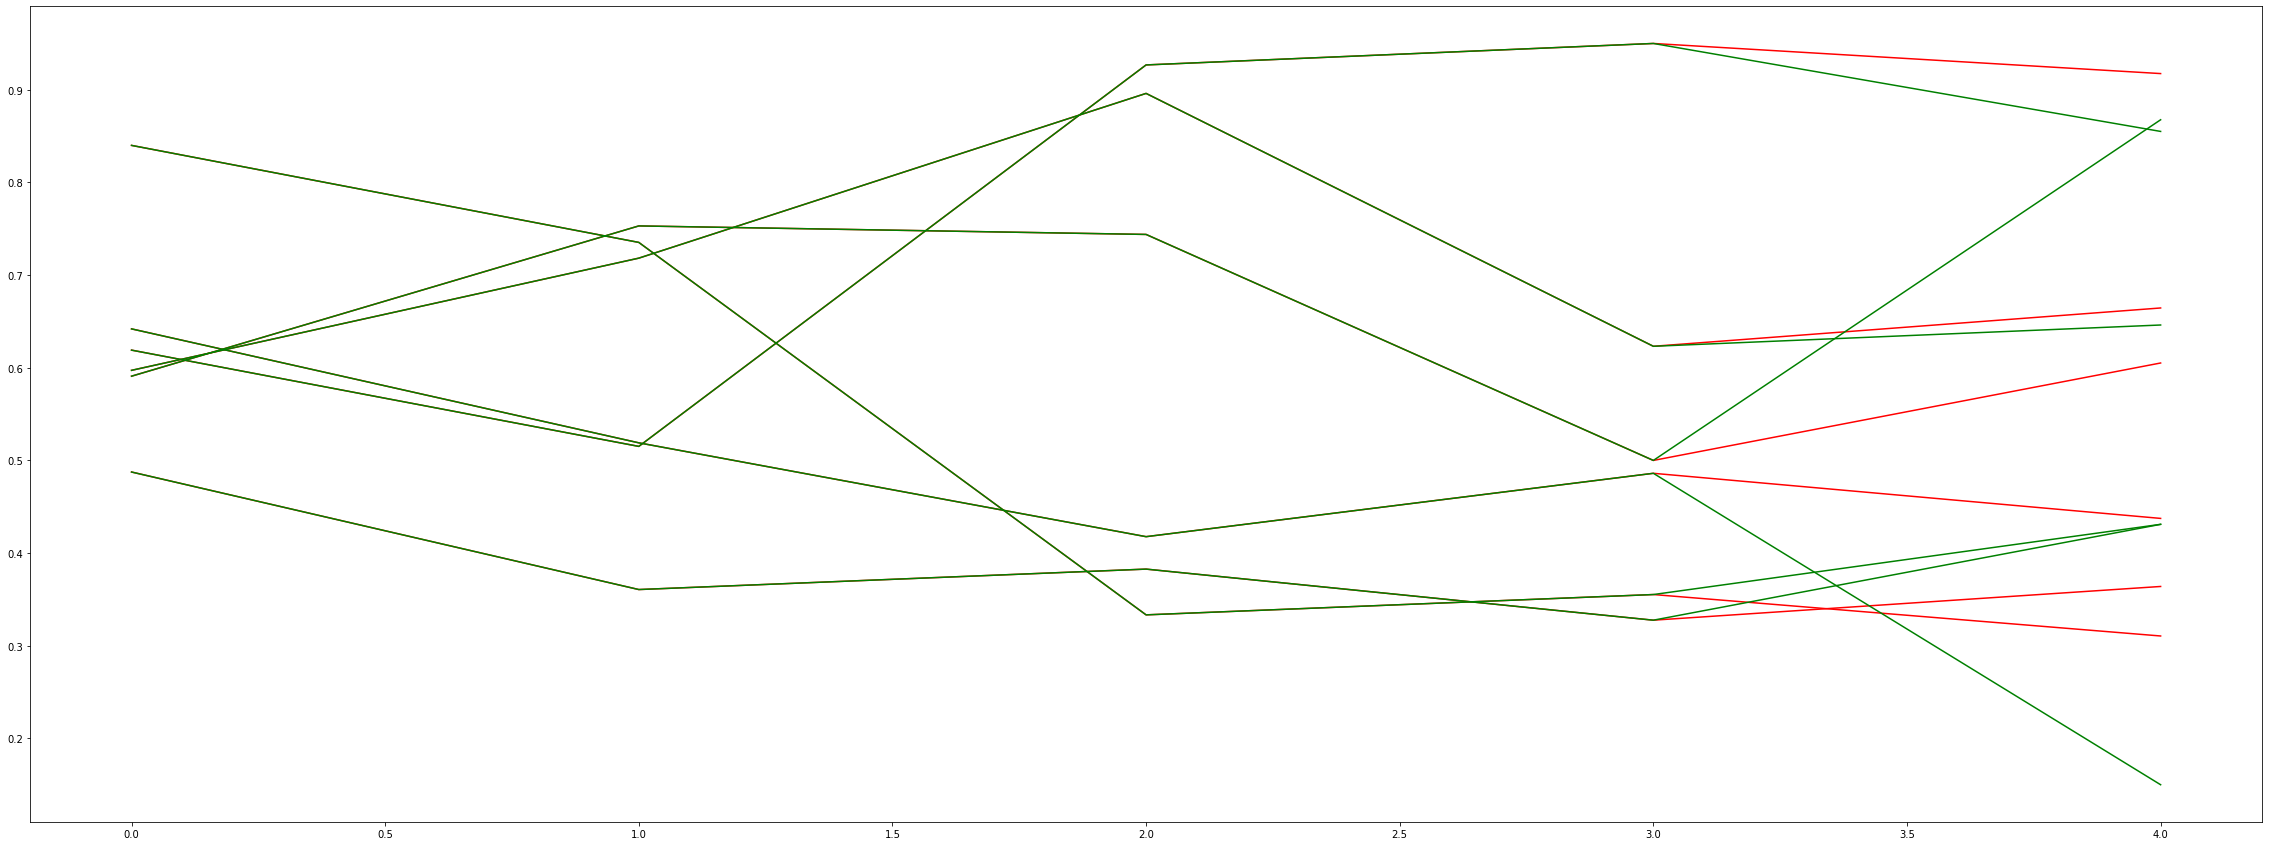

In [280]:
fig = plt.figure(figsize = (40,15))
x = 5
plt.plot([0,1,2,3,4], [y_compare.loc[0:x]['20152016p/g'],y_compare.loc[0:x]['20162017p/g'],y_compare.loc[0:x]['20172018p/g'],y_compare.loc[0:x]['20182019p/g'],y_compare.loc[0:x]['pred_unscaled']],color='red')
plt.plot([0,1,2,3,4], [y_compare.loc[0:x]['20152016p/g'],y_compare.loc[0:x]['20162017p/g'],y_compare.loc[0:x]['20172018p/g'],y_compare.loc[0:x]['20182019p/g'],y_compare.loc[0:x]['20192020p/g']],color='green')
